In [1]:
import pandas as pd
import rasterio 
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import glob
import seaborn as sns
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import metrics


In [2]:
df_val = pd.read_csv(f'tree_species_val.csv')
df_train = pd.read_csv(f'tree_species_train.csv')

df_val['model'] = 1
df_train['model'] = 0

df = pd.concat([df_val,df_train])

del df["coord_x_32VNH"]
del df["coord_y_32VNH"]
del df['Unnamed: 0']

In [3]:

# Rename values in TreeType column
df['tree'] = df['y'].replace({1:'Norway Spruce (C)',
                              2:'Elder (D)',
                              3:'Grandis (C)',
                              4:'Ash (D)',
                              5:'Beech (D)',
                              6:'Birch (D)', 
                              7:'Douglas (C)',
                              8:'Oak (D)',
                              9:'Krat (D)',
                              10:'Larch (C-D)',
                              11:'Nordmann Fir (C)',
                              12:'Noble Fir (C)',
                              13:'Red Oak Tree (D)',
                              14:'Red Fir (C)',
                              15:'Sitka Spruce (C)',
                              16:'Siberian Fir (C)'})


# Rename values in TreeType column
df['Type'] = df['y'].replace({1:'Coniferous',
                              2:'Deciduous',
                              3:'Coniferous',
                              4:'Deciduous',
                              5:'Deciduous',
                              6:'Deciduous', 
                              7:'Coniferous',
                              8:'Deciduous',
                              9:'Deciduous',
                              10:'Deciduous',
                              11:'Coniferous',
                              12:'Coniferous',
                              13:'Deciduous',
                              14:'Coniferous',
                              15:'Coniferous',
                              16:'Coniferous'})


# Rename values in TreeType column
class_names = ['Norway Spruce (C)',
               'Elder (D)',
               'Grandis (C)',
               'Ash (D)',
               'Beech (D)',
               'Birch (D)', 
               'Douglas (C)',
               'Oak (D)',
               'Krat (D)',
               'Larch (C-D)',
               'Nordmann Fir (C)',
               'Noble Fir (C)',
               'Red Oak Tree (D)',
               'Red Fir (C)',
               'Sitka Spruce (C)',
               'Siberian Fir (C)']

# Rename values in TreeType column
class_names_d = ['Elder (D)',
              'Ash (D)',
              'Beech (D)',
              'Birch (D)',
              'Oak (D)',
              'Krat (D)',
              'Larch (C-D)',
              'Red Oak Tree (D)']


C:\Users\ansu\AppData\Local\Temp\ipykernel_19076\1548639969.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['tree'] = df['y'].replace({1:'Norway Spruce (C)',
C:\Users\ansu\AppData\Local\Temp\ipykernel_19076\1548639969.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Type'] = df['y'].replace({1:'Coniferous',


In [4]:
l = df.columns.tolist()
l_split = [i.split('_', 1)[0] for i in l]
empty_list = set()
index_all = [x for x in l_split if x not in empty_list and (empty_list.add(x) or True)]
index_all[1:17]

['B02',
 'B03',
 'B04',
 'B05',
 'B06',
 'B07',
 'B08',
 'B11',
 'B12',
 'B8A',
 'ccmi',
 'ndmi',
 'ndti',
 'ndvi',
 're75',
 're8A6']

# Mean and Quarterly data

In [37]:
df_mean = df
for index in index_all[1:17]:  
    print(index)
    cols = [col for col in df.columns if index in col]
    df_index = df[cols]
    df_mean[f'mean_year_{index}'] = df_index.loc[:, cols].mean(axis = 1)
    Q = [cols[0:15],cols[15:30],cols[30:45],cols[45:60]]
    for i, q in enumerate(Q,1):
        df_mean[f'mean_year_{index}_Q{i}'] = df_index.loc[:, q].mean(axis = 1)


B02
B03
B04
B05
B06
B07
B08
B11
B12
B8A
ccmi
ndmi
ndti
ndvi
re75
re8A6


In [38]:
df_mean_selected = df_mean.iloc[:, 964:1110] 
df_mean_selected['model'] = df_mean['model'] 
df_mean_selected['y'] = df_mean['y'] 
df_mean_selected['Type'] = df_mean['Type'] 

# Only DECIDUOUS tree

In [39]:
df_train_d= df_mean_selected[(df_mean_selected.Type=='Deciduous')&(df_mean_selected.model==1)]
df_val_d= df_mean_selected[(df_mean_selected.Type=='Deciduous')&(df_mean_selected.model==0)]

del df_val_d['Type']
del df_val_d['model']
del df_train_d['model']
del df_train_d['Type']

In [40]:
train_features = df_train_d.drop('y', axis = 1)
train_labels =  np.array(df_train_d['y'])

test_features = df_val_d.drop('y',axis =1)
test_labels = np.array(df_val_d['y'])

In [41]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (12592, 80)
Training Labels Shape: (12592,)
Testing Features Shape: (21256, 80)
Testing Labels Shape: (21256,)


## Logistic Regression 

In [42]:
log_reg = LogisticRegression()
log_reg = log_reg.fit(train_features,train_labels)

c:\Users\ansu\Miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [43]:
training_prediction = log_reg.predict(train_features)
test_prediction = log_reg.predict(test_features)

#### We can check probability for first feature

In [44]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
prob = log_reg.predict_proba(train_features)

print('Probabilty for each feature:', prob[0])
print('Probabilty for each feature:', training_prediction[0])

Probabilty for each feature: [0.611372 0.037481 0.211563 0.039852 0.071414 0.001953 0.000030 0.026335]
Probabilty for each feature: 2


### TESTING

In [46]:
print("Precision, Recall, Confusion matrix, in TESTING \n")

# Precision Recall scores
print(metrics.classification_report(test_labels, test_prediction, digits=3))

Precision, Recall, Confusion matrix, in TESTING 

              precision    recall  f1-score   support

           2      0.568     0.637     0.600      2657
           4      0.358     0.257     0.299      2657
           5      0.611     0.719     0.661      2657
           6      0.556     0.411     0.473      2657
           8      0.361     0.428     0.392      2657
           9      0.382     0.410     0.396      2657
          10      0.822     0.784     0.802      2657
          13      0.588     0.607     0.598      2657

    accuracy                          0.532     21256
   macro avg      0.531     0.532     0.528     21256
weighted avg      0.531     0.532     0.528     21256



Text(0.5, 51.0, 'Predicted')

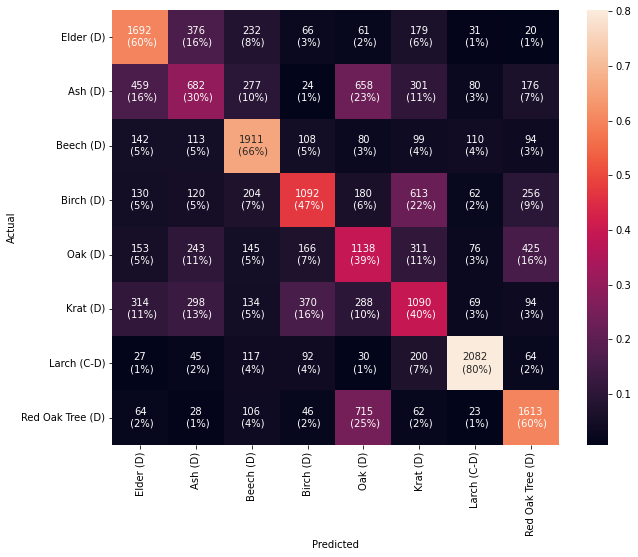

In [47]:
# Visualise classical Confusion Matrix

CM = confusion_matrix(y_true = test_labels, y_pred = test_prediction)

df_cm = pd.DataFrame(CM, index = [i for i in class_names_d], columns = [i for i in class_names_d])
precision = df_cm / df_cm.astype(float).sum(axis=0)
recall = df_cm / df_cm.astype(float).sum(axis=1)
f1 = (2 * ((precision*recall) / (precision+recall))).fillna(0)

labels = [f"{v1}\n ({round(v2*100)}%)\n ({round(v3*100)}%)\n ({round(v4*100)}%)" for v1, v2, v3, v4 in zip(df_cm.values.flatten(), precision.values.flatten(), recall.values.flatten(), f1.values.flatten())]
labels = [f"{v1}\n ({round(v4*100)}%)" for v1, v4 in zip(df_cm.values.flatten(), f1.values.flatten())]
labels = np.asarray(labels).reshape(len(class_names_d), len(class_names_d))

plt.figure(figsize = (10,8))
sns.heatmap(f1, annot=labels, fmt='')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Random Forest

In [48]:
# Instantiate and fit the RandomForestClassifier
forest = RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        n_jobs=-1,
        random_state=0)

In [49]:
forest.fit(train_features,train_labels)

training_prediction = forest.predict(train_features)
test_prediction = forest.predict(test_features)

In [50]:
print("Precision, Recall, Confusion matrix, in TESTING \n")

# Precision Recall scores
print(metrics.classification_report(test_labels, test_prediction, digits=3))

Precision, Recall, Confusion matrix, in TESTING 

              precision    recall  f1-score   support

           2      0.550     0.499     0.523      2657
           4      0.413     0.228     0.294      2657
           5      0.543     0.779     0.640      2657
           6      0.575     0.476     0.521      2657
           8      0.338     0.644     0.443      2657
           9      0.478     0.372     0.418      2657
          10      0.775     0.852     0.812      2657
          13      0.791     0.392     0.524      2657

    accuracy                          0.530     21256
   macro avg      0.558     0.530     0.522     21256
weighted avg      0.558     0.530     0.522     21256



Text(0.5, 24.0, 'Predicted')

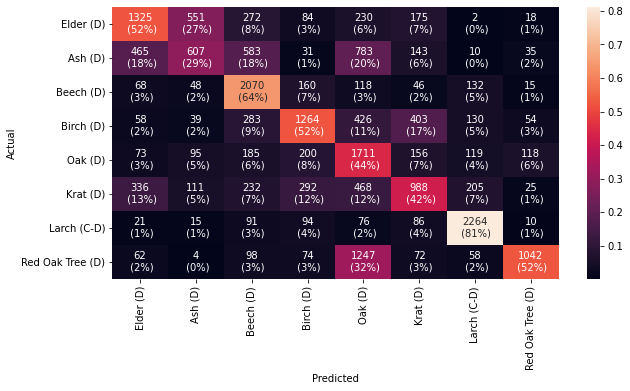

In [51]:
# Visualise classical Confusion Matrix

CM = confusion_matrix(y_true=test_labels, y_pred= test_prediction)

df_cm = pd.DataFrame(CM, index = [i for i in class_names_d], columns = [i for i in class_names_d])
precision = df_cm / df_cm.astype(float).sum(axis=0)
recall = df_cm / df_cm.astype(float).sum(axis=1)
f1 = (2 * ((precision*recall) / (precision+recall))).fillna(0)

labels = [f"{v1}\n ({round(v2*100)}%)\n ({round(v3*100)}%)\n ({round(v4*100)}%)" for v1, v2, v3, v4 in zip(df_cm.values.flatten(), precision.values.flatten(), recall.values.flatten(), f1.values.flatten())]
labels = [f"{v1}\n ({round(v4*100)}%)" for v1, v4 in zip(df_cm.values.flatten(), f1.values.flatten())]
labels = np.asarray(labels).reshape(len(class_names_d), len(class_names_d))

plt.figure(figsize = (10,5))
sns.heatmap(f1, annot=labels, fmt='')
plt.ylabel('Actual')
plt.xlabel('Predicted')

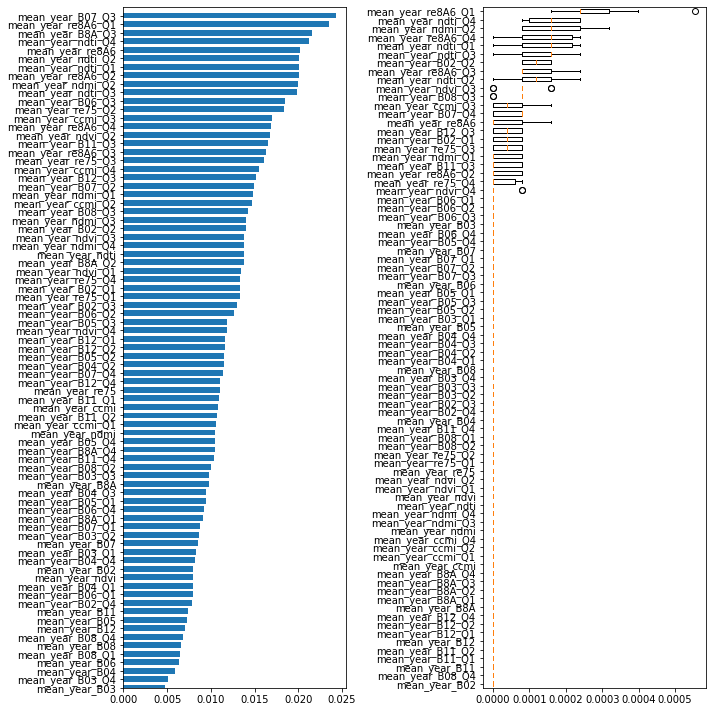

In [52]:
result = permutation_importance(forest,train_features, train_labels, n_repeats=10, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(forest.feature_importances_)
tree_indices = np.arange(0, len(forest.feature_importances_)) 

columns = df_train_d.columns[0:80]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.barh(tree_indices, forest.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(columns[tree_importance_sorted_idx])
ax1.set_ylim((0, len(forest.feature_importances_)))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=columns[perm_sorted_idx],
)
fig.tight_layout()
plt.show()


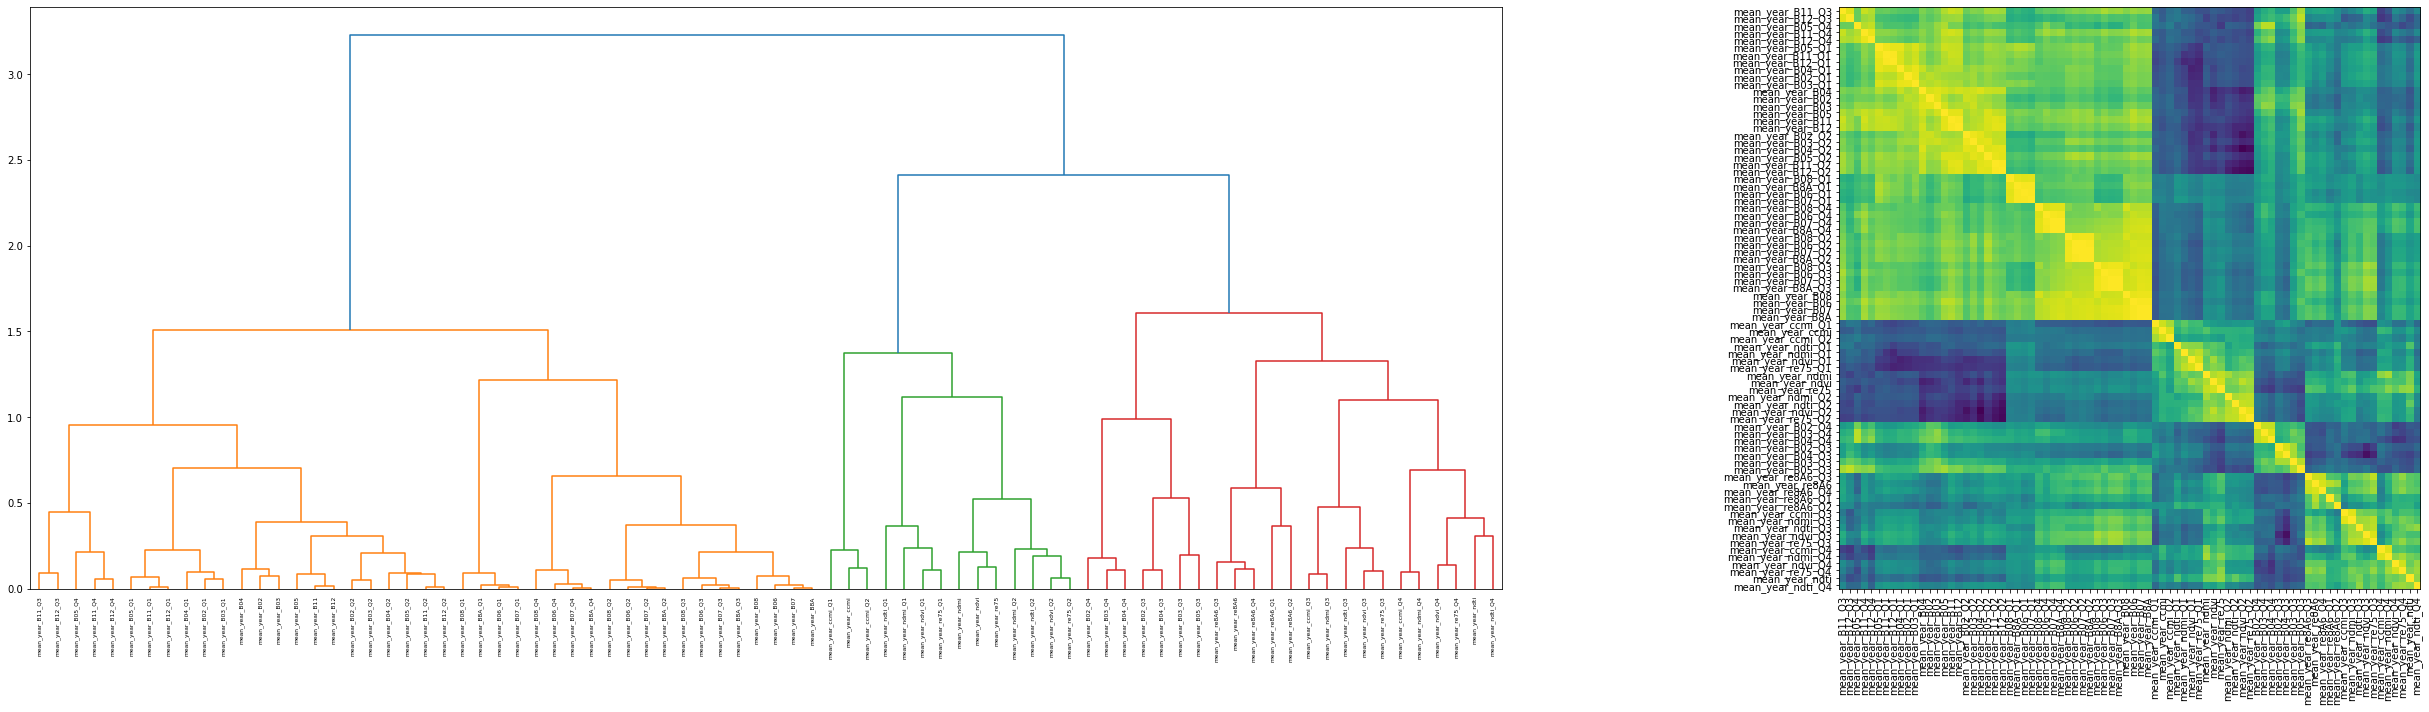

In [59]:
X = df_val_d[columns]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40, 10))
corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=columns, ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
fig.tight_layout()
plt.show()

# 10 important variables

In [62]:
df_train_d= df_mean_selected[(df_mean_selected.Type=='Deciduous') & (df_mean_selected.model==1)]
df_val_d= df_mean_selected[(df_mean_selected.Type=='Deciduous') & (df_mean_selected.model==0)]

del df_val_d['Type']
del df_val_d['model']
del df_train_d['model']
del df_train_d['Type']

columns_important = columns[perm_sorted_idx]
important_10 = columns_important.to_list()[-20:-1]


In [63]:
df_val_d_important= df_val_d[important_10]
df_val_d_important['y']=df_val_d['y']

df_train_d_important= df_train_d[important_10]
df_train_d_important['y']=df_train_d['y']


C:\Users\ansu\AppData\Local\Temp\ipykernel_19076\2918647831.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val_d_important['y']=df_val_d['y']
C:\Users\ansu\AppData\Local\Temp\ipykernel_19076\2918647831.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_d_important['y']=df_train_d['y']


In [64]:
train_features = df_train_d_important.drop('y', axis = 1)
train_labels =  np.array(df_train_d_important['y'])

test_features = df_val_d_important.drop('y',axis =1)
test_labels = np.array(df_val_d_important['y'])

              precision    recall  f1-score   support

           2      0.574     0.567     0.571      1574
           4      0.471     0.425     0.447      1574
           5      0.569     0.663     0.613      1574
           6      0.564     0.546     0.555      1574
           8      0.550     0.417     0.474      1574
           9      0.486     0.456     0.471      1574
          10      0.655     0.770     0.708      1574
          13      0.608     0.673     0.639      1574

    accuracy                          0.565     12592
   macro avg      0.560     0.565     0.560     12592
weighted avg      0.560     0.565     0.560     12592



c:\Users\ansu\Miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Text(0.5, 24.0, 'Predicted')

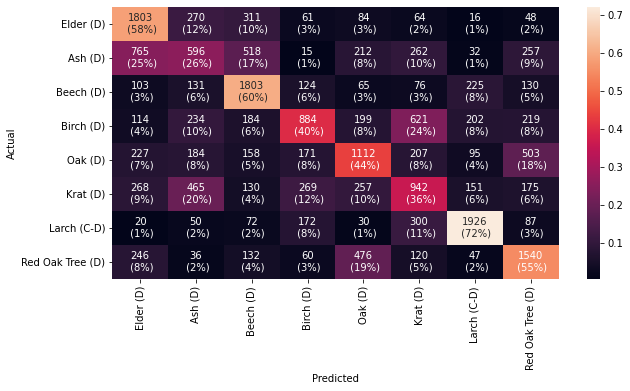

In [65]:

log_reg = LogisticRegression()
log_reg = log_reg.fit(train_features,train_labels)

training_prediction = log_reg.predict(train_features)
test_prediction = log_reg.predict(test_features)

# Precision Recall scores
print(metrics.classification_report(train_labels, training_prediction, digits=3))

# Visualise classical Confusion Matrix

CM = confusion_matrix(y_true=test_labels, y_pred= test_prediction)

df_cm = pd.DataFrame(CM, index = [i for i in class_names_d], columns = [i for i in class_names_d])
precision = df_cm / df_cm.astype(float).sum(axis=0)
recall = df_cm / df_cm.astype(float).sum(axis=1)
f1 = (2 * ((precision*recall) / (precision+recall))).fillna(0)

labels = [f"{v1}\n ({round(v2*100)}%)\n ({round(v3*100)}%)\n ({round(v4*100)}%)" for v1, v2, v3, v4 in zip(df_cm.values.flatten(), precision.values.flatten(), recall.values.flatten(), f1.values.flatten())]
labels = [f"{v1}\n ({round(v4*100)}%)" for v1, v4 in zip(df_cm.values.flatten(), f1.values.flatten())]
labels = np.asarray(labels).reshape(len(class_names_d), len(class_names_d))

plt.figure(figsize = (10,5))
sns.heatmap(f1, annot=labels, fmt='')
plt.ylabel('Actual')
plt.xlabel('Predicted')

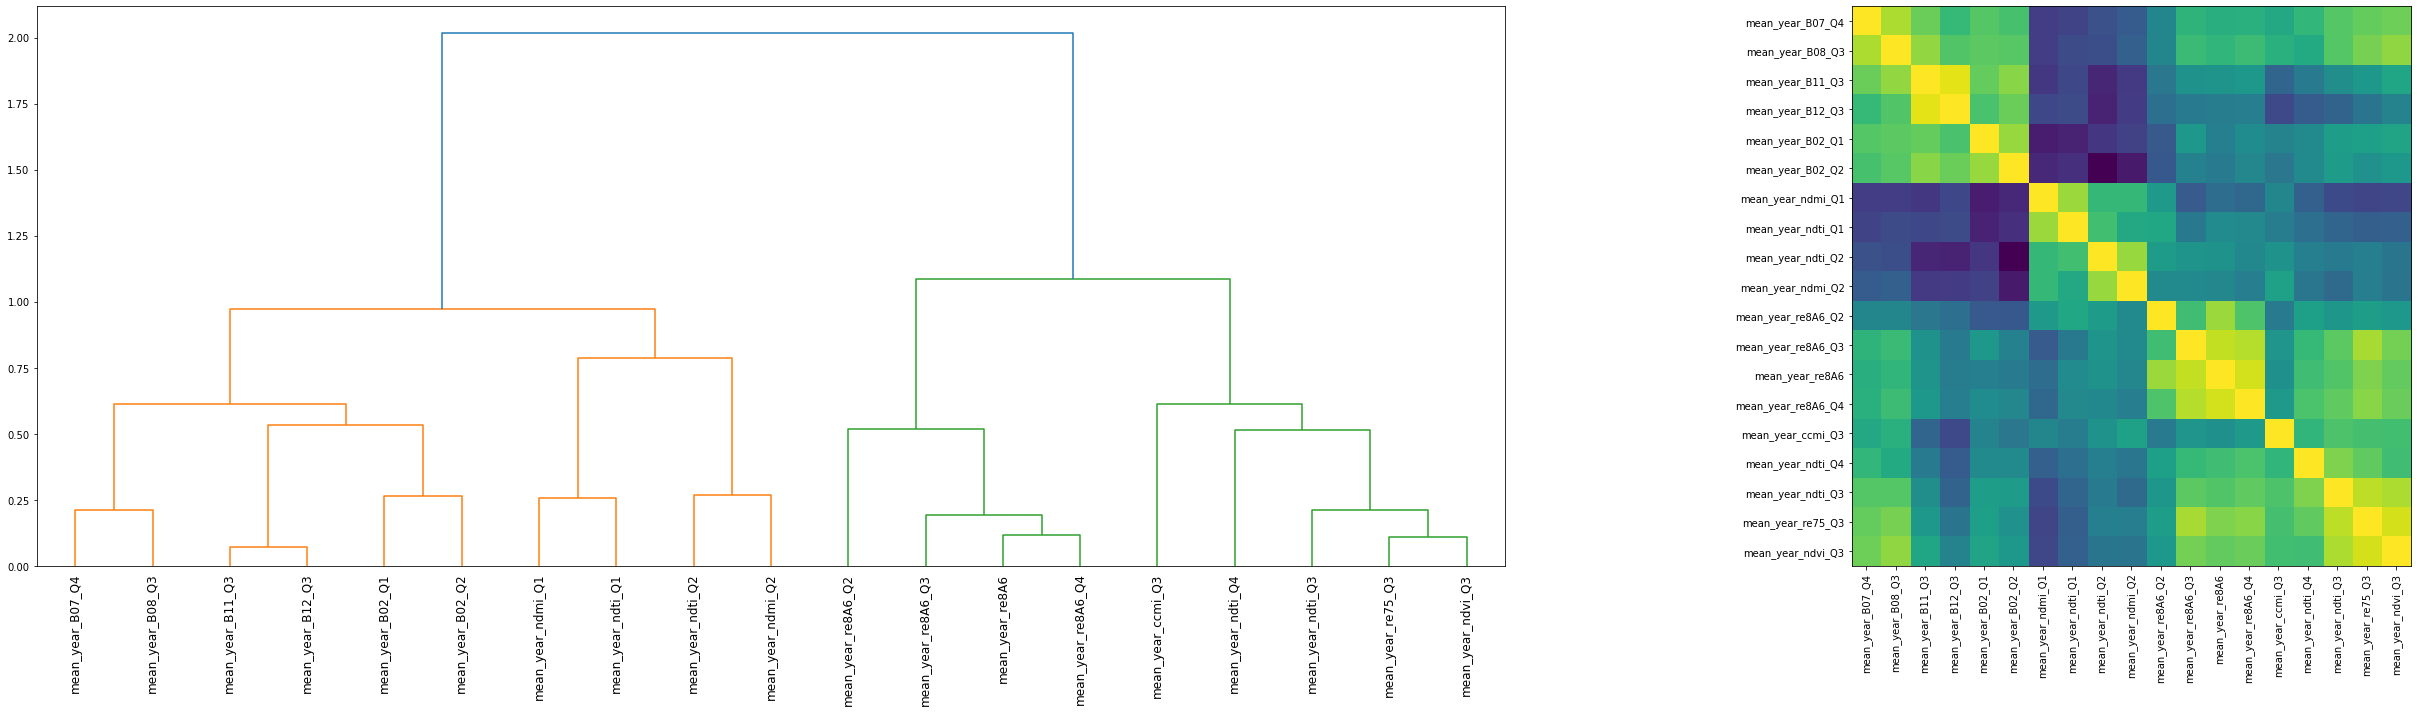

In [72]:
X = train_features
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40, 10))
corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=important_10, ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
fig.tight_layout()
plt.show()